# Bayesian Experimental Design for model selection

Script used to perform optimisation where a 6 step experiment is being design considering only the Bhattacharyya distance of RFP for the two models

   ............................................................................................................................................................................................................................................

### Import Required libraries

In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import seaborn as sns
from numba import jit
import gaussianprocess as gp
from fitderiv import fitderiv
import genutils as gu
import datetime
from bayes_opt import BayesianOptimization
from bayes_opt.observer import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs
import pickle

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import math


### Model 1 Functions (ODEs, Steady State and Event based representation)
* Lugagne et. al. Model

In [2]:
@jit
def model1(y,t,p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    
    # Parameters
    k_in_IPTG = p[0]
    k_out_IPTG = p[1]
    k_in_aTc = p[2]
    k_out_aTc = p[3]
    k_L_pm0 = p[4]
    k_L_pm = p[5]
    theta_T = p[6]
    theta_aTc = p[7]
    n_aTc = p[8]
    n_T = p[9];
    k_T_pm0 = p[10]
    k_T_pm = p[11]
    theta_L = p[12]
    theta_IPTG = p[13]
    n_IPTG = p[14]
    n_L = p[15]
    
    # ODEs
    dInd_dt = np.empty(4).tolist()
    
    if u_IPTG > y[0]:
        dInd_dt[0]=k_in_IPTG*(u_IPTG-y[0])
    else:
        dInd_dt[0]=k_out_IPTG*(u_IPTG-y[0])
    
    if u_aTc > y[2]:
        dInd_dt[1]=k_in_aTc*(u_aTc-y[1])
    else:
        dInd_dt[1]=k_out_aTc*(u_aTc-y[1])
    
    dInd_dt[2] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+(y[3]/theta_T*1/(1+(y[1]/theta_aTc)**n_aTc))**n_T))))-0.0165*y[2];
    dInd_dt[3] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+(y[2]/theta_L*1/(1+(y[0]/theta_IPTG)**n_IPTG))**n_L))))-0.0165*y[3];
    
    # Results
    return dInd_dt

def SteadyState1(p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    preRFP = I[2]
    preGFP = I[3]
    
    # Parameters
    k_in_IPTG = p[0]
    k_out_IPTG = p[1]
    k_in_aTc = p[2]
    k_out_aTc = p[3]
    k_L_pm0 = p[4]
    k_L_pm = p[5]
    theta_T = p[6]
    theta_aTc = p[7]
    n_aTc = p[8]
    n_T = p[9];
    k_T_pm0 = p[10]
    k_T_pm = p[11]
    theta_L = p[12]
    theta_IPTG = p[13]
    n_IPTG = p[14]
    n_L = p[15]
    
    # ODEs steady state equations
    alpha = np.empty(2)
    alpha[0] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+((preGFP/theta_T)*1/(1+(u_aTc/theta_aTc)**n_aTc))**n_T))))/0.0165
    alpha[1] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+((preRFP/theta_L)*1/(1+(u_IPTG/theta_IPTG)**n_IPTG))**n_L))))/0.0165
    
    # Results
    return alpha


def solve_coupled_ode1(ts, p, sp, inputs, ivss, pre):
    maxtime = len(ts);
    Nsp = len(sp);
    Nevents = len(sp)-1;
    Neq = 4;
    p = p
    
    final = np.zeros((maxtime,Neq))
    Y0 = np.empty(4)
    
    y_al = SteadyState1(p,ivss) # Calculation of initial guesses for steady state
    Y0[0] = pre[0]
    Y0[1] = pre[1]
    Y0[2] = y_al[0]
    Y0[3] = y_al[1]
    ssv = odeint(model1,Y0,np.linspace(0,24*60,(24*60)+1),args=(p,pre), rtol=1e-9,atol=1e-9, tcrit=np.array(range(0,24*60+1)))
    
    y0 = ssv[24*60,:]
    
    initialV = y0
    i = 0
    
    for q in range(0,Nevents):
        
        lts = len(ts[(sp[q]+1):sp[q+1]+1])  # General way to define the number of elements in each event series
        Tevent = ts[(sp[q]):sp[q+1]+1]  # General way to extract the times of each event
        I = inputs[i:(i+2)]
        
        if q == 0:
            
            part1 = odeint(model1,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))#, full_output =1)
            
        else:
            
            part1 = odeint(model1,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))
        
        initialV = part1[lts]
        i=i+2;
        
        for d in range((sp[q]),(sp[q]+lts+1)):
            
            final[d,:] = part1[d-sp[q]]

    return(final)



### Model 2 Functions (ODEs, Steady State and Event based representation)
* Intermediate Model (Single rate, no degradation)

In [3]:
@jit
def model2(y,t,p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    
    # Parameters
    k_IPTG = p[0]
    k_aTc = p[1]
    k_L_pm0 = p[2]
    k_L_pm = p[3]
    theta_T = p[4]
    theta_aTc = p[5]
    n_aTc = p[6]
    n_T = p[7];
    k_T_pm0 = p[8]
    k_T_pm = p[9]
    theta_L = p[10]
    theta_IPTG = p[11]
    n_IPTG = p[12]
    n_L = p[13]
    
    # ODEs
    dInd_dt = np.empty(4).tolist()
    dInd_dt[0] = k_IPTG*(u_IPTG-y[0]);
    dInd_dt[1] = k_aTc*(u_aTc-y[1]);
    dInd_dt[2] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+(y[3]/theta_T*1/(1+(y[1]/theta_aTc)**n_aTc))**n_T))))-0.0165*y[2];
    dInd_dt[3] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+(y[2]/theta_L*1/(1+(y[0]/theta_IPTG)**n_IPTG))**n_L))))-0.0165*y[3];
    
    # Results
    return dInd_dt

def SteadyState2(p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    preRFP = I[2]
    preGFP = I[3]
    
    # Parameters
    k_IPTG = p[0]
    k_aTc = p[1]
    k_L_pm0 = p[2]
    k_L_pm = p[3]
    theta_T = p[4]
    theta_aTc = p[5]
    n_aTc = p[6]
    n_T = p[7];
    k_T_pm0 = p[8]
    k_T_pm = p[9]
    theta_L = p[10]
    theta_IPTG = p[11]
    n_IPTG = p[12]
    n_L = p[13]
    
    # ODEs steady state equations
    alpha = np.empty(2)
    alpha[0] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+((preGFP/theta_T)*1/(1+(u_aTc/theta_aTc)**n_aTc))**n_T))))/0.0165
    alpha[1] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+((preRFP/theta_L)*1/(1+(u_IPTG/theta_IPTG)**n_IPTG))**n_L))))/0.0165
    
    # Results
    return alpha


def solve_coupled_ode2(ts, p, sp, inputs, ivss, pre):
    maxtime = len(ts);
    Nsp = len(sp);
    Nevents = len(sp)-1;
    Neq = 4;
    p = p
    
    final = np.zeros((maxtime,Neq))
    Y0 = np.empty(4)
    
    y_al = SteadyState2(p,ivss) # Calculation of initial guesses for steady state
    Y0[0] = pre[0]
    Y0[1] = pre[1]
    Y0[2] = y_al[0]
    Y0[3] = y_al[1]
    ssv = odeint(model2,Y0,np.linspace(0,24*60,(24*60)+1),args=(p,pre), rtol=1e-9,atol=1e-9, tcrit=np.array(range(0,24*60+1)))
    
    y0 = ssv[24*60,:]
    
    initialV = y0
    i = 0
    
    for q in range(0,Nevents):
        
        lts = len(ts[(sp[q]+1):sp[q+1]+1])  # General way to define the number of elements in each event series
        Tevent = ts[(sp[q]):sp[q+1]+1]  # General way to extract the times of each event
        I = inputs[i:(i+2)]
        
        if q == 0:
            
            part1 = odeint(model2,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))#, full_output =1)
            
        else:
            
            part1 = odeint(model2,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))
        
        initialV = part1[lts]
        i=i+2;
        
        for d in range((sp[q]),(sp[q]+lts+1)):
            
            final[d,:] = part1[d-sp[q]]

    return(final)



### Model 3 Functions (ODEs, Steady State and Event based representation)
* Lucia's Model

In [4]:
@jit
def model3(y,t,p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    
    # Parameters
    k_IPTG = p[0]
    k_aTc = p[1]
    k_L_pm0 = p[2]
    k_L_pm = p[3]
    theta_T = p[4]
    theta_aTc = p[5]
    n_aTc = p[6]
    n_T = p[7];
    k_T_pm0 = p[8]
    k_T_pm = p[9]
    theta_L = p[10]
    theta_IPTG = p[11]
    n_IPTG = p[12]
    n_L = p[13]
    
    # ODEs
    dInd_dt = np.empty(4).tolist()
    dInd_dt[0] = k_IPTG*(u_IPTG-y[0])-0.0165*y[0];
    dInd_dt[1] = k_aTc*(u_aTc-y[1])-0.0165*y[1];
    dInd_dt[2] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+(y[3]/theta_T*1/(1+(y[1]/theta_aTc)**n_aTc))**n_T))))-0.0165*y[2];
    dInd_dt[3] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+(y[2]/theta_L*1/(1+(y[0]/theta_IPTG)**n_IPTG))**n_L))))-0.0165*y[3];
    
    # Results
    return dInd_dt

def SteadyState3(p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    preRFP = I[2]
    preGFP = I[3]
    
    # Parameters
    k_IPTG = p[0]
    k_aTc = p[1]
    k_L_pm0 = p[2]
    k_L_pm = p[3]
    theta_T = p[4]
    theta_aTc = p[5]
    n_aTc = p[6]
    n_T = p[7];
    k_T_pm0 = p[8]
    k_T_pm = p[9]
    theta_L = p[10]
    theta_IPTG = p[11]
    n_IPTG = p[12]
    n_L = p[13]
    
    # ODEs steady state equations
    alpha = np.empty(4)
    alpha[0] = (k_IPTG*u_IPTG)/(k_IPTG+0.0165)
    alpha[1] = (k_aTc*u_aTc)/(k_aTc+0.0165)
    alpha[2] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+((preGFP/theta_T)*1/(1+(alpha[1]/theta_aTc)**n_aTc))**n_T))))/0.0165
    alpha[3] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+((preRFP/theta_L)*1/(1+(alpha[0]/theta_IPTG)**n_IPTG))**n_L))))/0.0165
    
    # Results
    return alpha


def solve_coupled_ode3(ts, p, sp, inputs, ivss, pre):
    maxtime = len(ts);
    Nsp = len(sp);
    Nevents = len(sp)-1;
    Neq = 4;
    p = p
    
    final = np.zeros((maxtime,Neq))
    
    y_al = SteadyState3(p,ivss) # Calculation of initial guesses for steady state
    
    ssv = odeint(model3,y_al,np.linspace(0,24*60,(24*60)+1),args=(p,pre), rtol=1e-9,atol=1e-9, tcrit=np.array(range(0,24*60+1)))
    
    y0 = ssv[24*60,:]
    
    initialV = y0
    i = 0
    
    for q in range(0,Nevents):
        
        lts = len(ts[(sp[q]+1):sp[q+1]+1])  # General way to define the number of elements in each event series
        Tevent = ts[(sp[q]):sp[q+1]+1]  # General way to extract the times of each event
        I = inputs[i:(i+2)]
        
        if q == 0:
            
            part1 = odeint(model3,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))#, full_output =1)
            
        else:
            
            part1 = odeint(model3,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))
        
        initialV = part1[lts]
        i=i+2;
        
        for d in range((sp[q]),(sp[q]+lts+1)):
            
            final[d,:] = part1[d-sp[q]]
        
        
        
    
    return(final)

### Functions to simulate the 3 models for all parameter draws

In [5]:
def solveALL (ts, pD, sp, inputs, ivss, pre, model):
    
    AllSol = np.empty((len(ts),len(pD[:,1])*2))
    AllSolTest = np.empty(((round(len(ts)/5)+1),len(pD[:,1])*2))
    for drawInd in range(0,len(pD[:,1])):
        
        p = pD[drawInd,:]
        if model == 'M1':
            temp = solve_coupled_ode1(ts, p, sp, inputs, ivss, pre)
        elif model == 'M2':
            temp = solve_coupled_ode2(ts, p, sp, inputs, ivss, pre)
        elif model == 'M3':
            temp = solve_coupled_ode3(ts, p, sp, inputs, ivss, pre)
        else:
            print('Please, select a correct model as M1, M2 or M3 for the desired one')

        AllSolTest[:,drawInd] = temp[:,2][::5]
        AllSolTest[:,drawInd+(len(pD[:,1]))] = temp[:,3][::5]

    return(AllSolTest)
    

### Example:

In [6]:
ivss = [1,1e-7,1363.193,28.510]
pre = [1,1e-7]
inputs = np.empty(18) # What needs to be optimised    --> example: [1e-7,100,1,1e-7]*4+[1e-7,100]
evnT = [int(i) for i in list(np.linspace(0,(24*60),10))]
t = np.linspace(0,(24*60),(24*60)+1)
pM3 = np.asarray(pd.read_csv("ParametersCSV/draws_ALL_Model3.stan.csv"))

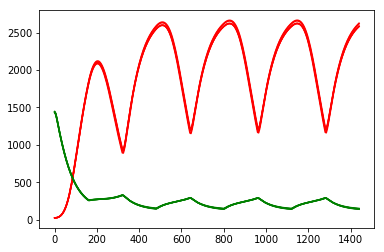

In [15]:
p = pM3[0:5,:]
test = solveALL(t,p,evnT,[1e-7,100,1,1e-7]*4+[1e-7,100],ivss,pre, 'M3')
plt.figure()
plt.plot(t[::5], test[:,0:5], 'r')
plt.plot(t[::5], test[:,5:10], 'g')
plt.show()

### Bhattacharyya distance function:

In [7]:

def BhattacharyyaDist (mu1, mu2, sd1, sd2):
    E = (sd1+sd2)/2
    Em1 = np.linalg.inv(E)
    dE = abs(np.linalg.det(E))

    t1 = np.matrix.transpose((np.matrix.transpose(np.matrix(mu1))-np.matrix.transpose(np.matrix(mu2))))
    t2 = np.matrix.transpose(np.matrix(mu1))-np.matrix.transpose(np.matrix(mu2))
    
    ft = (1/8)*t1*Em1*t2
    st = dE/np.sqrt(abs(np.linalg.det(sd1))*abs(np.linalg.det(sd2)))
    
    bhd = ft+0.5*np.log(st)
    
    return(float(bhd))



### Definition of the utility function:

In [8]:

def utility2 (IPTG1, IPTG2, IPTG3, IPTG4, IPTG5, IPTG6,
             aTc1, aTc2, aTc3, aTc4, aTc5, aTc6):
    
    # Definition of inputs for the ODEs
        
    inputs = [round(IPTG1,2)+1e-7, int(aTc1)+1e-7, round(IPTG2,2)+1e-7, int(aTc2)+1e-7,
              round(IPTG3,2)+1e-7, int(aTc3)+1e-7, round(IPTG4,2)+1e-7, int(aTc4)+1e-7,
              round(IPTG5,2)+1e-7, int(aTc5)+1e-7, round(IPTG6,2)+1e-7, int(aTc6)+1e-7]
    
    # Initial values for steady state and inputs
    ivss = [1,1e-7,1363.193,28.510]
    pre = [1,1e-7]
    # Event switches and inputs
    sp = [int(i) for i in list(np.linspace(0,(24*60),7))]
    t =  np.linspace(0,(24*60),(24*60)+1)
    
    # load parameter draws for the two models
    pM1 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model1.stan.csv"))
    pM2 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model2.stan.csv"))
    
    # Simulation of the system for the two models and extract of results
    solM1 = solveALL(t, pM1, sp, inputs, ivss, pre, 'M1')
    solM2 = solveALL(t, pM2, sp, inputs, ivss, pre, 'M2')
    
    RFP_M1 = solM1[:,0:len(pM1[:,1])]
    GFP_M1 = solM1[:,len(pM1[:,1]):(len(pM1[:,1])*2)]
    
    RFP_M2 = solM2[:,0:len(pM2[:,1])]
    GFP_M2 = solM2[:,len(pM2[:,1]):(len(pM2[:,1])*2)]
    
    # Gaussian Process Regression and Reduction
    
    # Means and standard deviations for each time point for each species and for each model
    tgp = np.linspace(0,(24*60),round(24*60/5)+1)
    
    muR3 = RFP_M2.mean(axis = 1) # Model 2, RFP
    sdR3 = RFP_M2.std(axis = 1)
#     muG3 = GFP_M2.mean(axis = 1) # Model 2, GFP
#     sdG3 = GFP_M2.std(axis = 1)
    muR2 = RFP_M1.mean(axis = 1) # Model 1, RFP
    sdR2 = RFP_M1.std(axis = 1)
#     muG2 = GFP_M1.mean(axis = 1) # Model 1, GFP
#     sdG2 = GFP_M1.std(axis = 1)

    # Gaussian Process regression
    gR3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR3, (sdR3**2)) # RFP, Model 2
    gR3.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gR3.predict(tgp)
    
#     gG3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG3, (sdG3**2)) # GFP, Model 2
#     gG3.findhyperparameters(noruns=15, optmessages = False, quiet = True)
#     gG3.predict(tgp)
    
    gR2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR2, (sdR2**2)) # RFP, Model 1
    gR2.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gR2.predict(tgp)
    
#     gG2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG2, (sdG2**2)) # GFP, Model 1
#     gG2.findhyperparameters(noruns=15, optmessages = False, quiet = True)
#     gG2.predict(tgp)
    
    # Time points reduction

    muref = list(np.matrix.transpose((np.random.multivariate_normal(gR3.mnp, gR3.covp, 2000)))[::10])
    tref = list(tgp[::10])

    g2R3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2R3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2R3.predict(tref)

    
    muref = list(np.matrix.transpose((np.random.multivariate_normal(gR2.mnp, gR2.covp, 2000)))[::10])
    tref = list(tgp[::10])

    g2R2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2R2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2R2.predict(tref)

    
#     muref = list(np.matrix.transpose((np.random.multivariate_normal(gG3.mnp, gG3.covp, 2000)))[::10])
#     tref = list(tgp[::10])

#     g2G3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
#     g2G3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
#     g2G3.predict(tref)

    
#     muref = list(np.matrix.transpose((np.random.multivariate_normal(gG2.mnp, gG2.covp, 2000)))[::10])
#     tref = list(tgp[::10])

    
#     g2G2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
#     g2G2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
#     g2G2.predict(tref)

    
    # Bhattacharyya distance:
    bdR = BhattacharyyaDist(g2R3.mnp, g2R2.mnp, g2R3.covp, g2R2.covp)
#     bdG = BhattacharyyaDist(g2G3.mnp, g2G2.mnp, g2G3.covp, g2G2.covp)
    
    # Utility function value
    u_B = (bdR)

    return(u_B)
    


### Bayesian Optimisation: 

In [9]:
# Bounded region of parameter space

pbounds = {'IPTG1': (0, 1), 'IPTG2': (0, 1), 'IPTG3': (0, 1), 'IPTG4': (0, 1),
           'IPTG5': (0, 1), 'IPTG6': (0, 1),
           'aTc1': (0, 100), 'aTc2': (0, 100), 'aTc3': (0, 100), 'aTc4': (0, 100), 
           'aTc5': (0, 100), 'aTc6': (0, 100)}


Setting Bayesian Optimisation with our utility function

In [10]:
optimizer3 = BayesianOptimization(
    f=utility2,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1324,
) 

Begin optimisation rutine

In [24]:
optimizer3.maximize(
    init_points=0,
    n_iter=197,
    alpha=1e-2,
    n_restarts_optimizer=3, 
#     acq="ei", 
#     xi=1e-4
)

|   iter    |  target   |   IPTG1   |   IPTG2   |   IPTG3   |   IPTG4   |   IPTG5   |   IPTG6   |   aTc1    |   aTc2    |   aTc3    |   aTc4    |   aTc5    |   aTc6    |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  808      |  4.035e+0 |  0.5707   |  0.7138   |  0.3606   |  0.1352   |  0.8996   |  0.7349   |  30.6     |  30.96    |  35.51    |  42.56    |  87.53    |  2.175    |
|  809      |  2.084e+0 |  0.5562   |  0.3072   |  0.5576   |  0.2309   |  0.461    |  0.2513   |  22.3     |  24.95    |  38.05    |  49.65    |  86.24    |  6.61     |
|  810      |  6.597e+0 |  0.6342   |  0.5199   |  0.7739   |  0.1665   |  0.5183   |  0.9965   |  28.97    |  25.1     |  31.08    |  38.9     |  81.99    |  3.484    |
|  811      |  241.9    |  0.01466  |  0.4269   |  0.8207   |  0.5959   |  0.2645   |  0.1316   |  4.728    |  67.36    |  65.66    |  56.43    |  99.

|  818      |  8.977e+0 |  0.2888   |  0.08076  |  0.1082   |  0.862    |  0.4402   |  0.4709   |  46.61    |  31.75    |  39.11    |  57.04    |  61.81    |  6.795    |
|  819      |  1.721e+0 |  0.8253   |  0.398    |  0.7682   |  0.6916   |  0.3317   |  0.5171   |  25.33    |  18.55    |  32.32    |  39.57    |  89.05    |  26.55    |
|  820      |  370.0    |  0.5093   |  0.319    |  0.2446   |  0.5825   |  0.04389  |  0.7958   |  12.49    |  69.37    |  12.76    |  63.63    |  0.3209   |  47.03    |
|  821      |  3.116e+0 |  0.6319   |  0.126    |  0.02628  |  0.1015   |  0.8004   |  0.921    |  35.71    |  23.87    |  26.55    |  59.94    |  98.02    |  5.602    |
|  822      |  3.113e+0 |  0.07407  |  0.874    |  0.6425   |  0.9843   |  0.689    |  0.008887 |  37.79    |  40.72    |  57.44    |  0.8225   |  31.78    |  25.31    |
|  823      |  3.798e+0 |  0.4731   |  0.4273   |  0.7214   |  0.529    |  0.5769   |  0.3498   |  31.43    |  27.47    |  31.51    |  57.89    |  90.

|  830      |  5.472e+0 |  0.3684   |  0.7009   |  0.7445   |  0.9814   |  0.2936   |  0.356    |  37.64    |  36.88    |  44.95    |  42.21    |  40.54    |  30.63    |
|  831      |  4.392e+0 |  0.1226   |  0.6769   |  0.123    |  0.08566  |  0.3722   |  0.632    |  22.82    |  16.26    |  69.87    |  54.83    |  86.01    |  17.23    |
|  832      |  1.545e+0 |  0.2974   |  0.02099  |  0.4902   |  0.9411   |  0.02064  |  0.01455  |  59.1     |  35.02    |  30.59    |  47.9     |  54.21    |  9.44     |
|  833      |  1.88e+04 |  0.3723   |  0.1873   |  0.5754   |  0.5622   |  0.8894   |  0.1302   |  29.21    |  23.44    |  27.31    |  41.23    |  89.25    |  27.35    |
|  834      |  1.808e+0 |  0.2505   |  0.4936   |  0.6955   |  0.6232   |  0.2925   |  0.4722   |  31.06    |  20.33    |  31.89    |  45.32    |  82.96    |  6.395    |
|  835      |  2.811e+0 |  0.4893   |  0.9836   |  0.8558   |  0.8149   |  0.2666   |  0.6572   |  21.33    |  21.01    |  38.74    |  47.76    |  85.

|  841      |  2.046e+0 |  0.7276   |  0.7663   |  0.05432  |  0.5173   |  0.3037   |  0.5445   |  46.93    |  58.29    |  24.37    |  61.31    |  92.04    |  54.84    |
|  842      |  2.776e+0 |  0.2748   |  0.9601   |  0.5788   |  0.5457   |  0.06466  |  0.4639   |  24.48    |  15.2     |  22.66    |  47.28    |  91.2     |  13.05    |
|  843      |  1.521e+0 |  0.7857   |  0.2036   |  0.4797   |  0.5072   |  0.3391   |  0.405    |  28.4     |  16.32    |  34.69    |  48.68    |  82.93    |  10.78    |
|  844      |  5.234e+0 |  0.1589   |  0.9941   |  0.8238   |  0.04002  |  0.04759  |  0.7651   |  26.83    |  19.7     |  32.93    |  44.86    |  82.53    |  12.03    |
|  845      |  5.306e+0 |  0.9842   |  0.2227   |  0.808    |  0.7938   |  0.5251   |  0.09631  |  25.15    |  37.12    |  30.06    |  64.02    |  80.68    |  36.9     |
|  846      |  2.833e+0 |  0.8757   |  0.7069   |  0.2098   |  0.9165   |  0.7668   |  0.3565   |  20.04    |  39.76    |  28.18    |  57.64    |  89.

|  853      |  1.648e+0 |  0.9193   |  0.1989   |  0.7102   |  0.669    |  0.7714   |  0.5673   |  30.03    |  25.35    |  32.3     |  41.03    |  85.19    |  2.566    |
|  854      |  1.019e+0 |  0.8306   |  0.001187 |  0.6885   |  0.9515   |  0.06876  |  0.1836   |  85.64    |  41.75    |  49.92    |  49.98    |  47.76    |  57.89    |
|  855      |  3.384e+0 |  0.2826   |  0.9437   |  0.5173   |  0.02446  |  0.4395   |  0.7883   |  30.78    |  16.99    |  33.86    |  45.91    |  94.75    |  18.16    |
|  856      |  1.972e+0 |  0.1877   |  0.2938   |  0.8715   |  0.6533   |  0.9021   |  0.5814   |  50.4     |  49.92    |  81.9     |  70.28    |  71.15    |  45.64    |
|  857      |  6.243e+0 |  0.7319   |  0.5336   |  0.2235   |  0.6022   |  0.004101 |  0.482    |  20.13    |  22.55    |  21.44    |  45.06    |  93.99    |  22.07    |
|  858      |  449.4    |  0.4586   |  0.3926   |  0.8505   |  0.1965   |  0.8224   |  0.8205   |  94.27    |  47.97    |  65.84    |  13.3     |  85.

|  865      |  3.889e+0 |  0.3195   |  0.3677   |  0.8479   |  0.02428  |  0.07682  |  0.2389   |  23.96    |  10.87    |  16.29    |  41.0     |  94.83    |  7.274    |
|  866      |  1.13e+04 |  0.9537   |  0.6279   |  0.772    |  0.9175   |  0.5876   |  0.5859   |  29.4     |  23.93    |  34.29    |  53.01    |  91.25    |  12.59    |
|  867      |  1.705e+0 |  0.04722  |  0.5317   |  0.32     |  0.7699   |  0.4074   |  0.2928   |  25.64    |  88.82    |  97.12    |  88.08    |  78.3     |  40.37    |
|  868      |  8.014e+0 |  0.6866   |  0.6281   |  0.1698   |  0.9382   |  0.4507   |  0.5691   |  12.99    |  26.59    |  21.61    |  72.77    |  19.09    |  52.77    |
|  869      |  1.677e+0 |  0.4576   |  0.779    |  0.5112   |  0.93     |  0.8652   |  0.8058   |  23.59    |  26.53    |  37.59    |  47.93    |  87.4     |  10.97    |
|  870      |  2.52e+03 |  0.3645   |  0.1515   |  0.005966 |  0.4973   |  0.5619   |  0.1215   |  83.33    |  50.88    |  78.88    |  48.38    |  76.

|  877      |  2.319e+0 |  0.7197   |  0.9477   |  0.248    |  0.4596   |  0.4085   |  0.9929   |  29.67    |  18.81    |  3.45     |  32.22    |  81.51    |  77.66    |
|  878      |  635.1    |  0.9291   |  0.4028   |  0.5038   |  0.8688   |  0.07021  |  0.1621   |  52.15    |  2.108    |  11.46    |  59.49    |  1.754    |  43.93    |
|  879      |  2.011e+0 |  0.01597  |  0.7001   |  0.4754   |  0.3896   |  0.2147   |  0.3463   |  24.85    |  23.75    |  44.73    |  44.27    |  95.9     |  16.05    |
|  880      |  3.936e+0 |  0.3227   |  0.5513   |  0.5891   |  0.5018   |  0.5605   |  0.4898   |  24.92    |  31.63    |  31.49    |  59.98    |  91.13    |  9.253    |
|  881      |  1.111e+0 |  0.05212  |  0.2773   |  0.03504  |  0.791    |  0.8541   |  0.6534   |  64.56    |  31.86    |  31.13    |  72.06    |  72.65    |  87.36    |
|  882      |  9.509e+0 |  0.2888   |  0.7063   |  0.1974   |  0.454    |  0.9609   |  0.01327  |  26.86    |  21.27    |  33.83    |  45.57    |  89.

|  889      |  2.074e+0 |  0.2444   |  0.9676   |  0.7206   |  0.9146   |  0.4258   |  0.3689   |  28.56    |  26.87    |  30.09    |  40.27    |  85.04    |  29.99    |
|  890      |  2.637e+0 |  0.2058   |  0.8146   |  0.6615   |  0.8813   |  0.732    |  0.6648   |  71.4     |  8.82     |  59.4     |  60.65    |  36.47    |  16.99    |
|  891      |  2.702e+0 |  0.7254   |  0.6863   |  0.1637   |  0.03031  |  0.2553   |  0.02442  |  27.99    |  42.23    |  38.85    |  56.28    |  90.93    |  76.29    |
|  892      |  1.287e+0 |  0.9901   |  0.2961   |  0.656    |  0.9175   |  0.02679  |  0.1376   |  55.66    |  28.8     |  21.81    |  33.6     |  56.16    |  35.12    |
|  893      |  1.315e+0 |  0.2052   |  0.9892   |  0.9281   |  0.6108   |  0.03902  |  0.1697   |  27.38    |  35.85    |  24.99    |  69.91    |  77.72    |  35.49    |
|  894      |  1.012e+0 |  0.4287   |  0.7615   |  0.5783   |  0.1668   |  0.7618   |  0.2678   |  48.06    |  9.996    |  53.95    |  96.57    |  71.

|  900      |  1.204e+0 |  0.6863   |  0.3736   |  0.3919   |  0.9496   |  0.5089   |  0.9226   |  16.65    |  67.5     |  59.97    |  40.25    |  82.46    |  4.713    |
|  901      |  2.203e+0 |  0.2503   |  0.8547   |  0.858    |  0.2015   |  0.9283   |  0.4465   |  87.26    |  1.051    |  24.22    |  72.78    |  54.97    |  44.39    |
|  902      |  827.2    |  0.336    |  0.1792   |  0.01795  |  0.3371   |  0.4617   |  0.641    |  4.671    |  98.26    |  91.9     |  52.34    |  51.54    |  79.55    |
|  903      |  1.162e+0 |  0.5698   |  0.5627   |  0.3739   |  0.1925   |  0.3404   |  0.9821   |  26.02    |  22.51    |  29.92    |  50.95    |  86.4     |  10.0     |
|  904      |  908.1    |  0.8854   |  0.5831   |  0.3959   |  0.3858   |  0.5794   |  0.276    |  60.59    |  48.58    |  73.03    |  11.08    |  79.04    |  50.01    |
|  905      |  6.631e+0 |  0.7791   |  0.07298  |  0.0602   |  0.7925   |  0.5227   |  0.9452   |  28.69    |  16.68    |  32.01    |  43.48    |  92.

|  911      |  2.23e+03 |  0.7876   |  0.9031   |  0.8681   |  0.5553   |  0.1862   |  0.4628   |  30.43    |  20.78    |  29.05    |  36.7     |  78.33    |  8.881    |
|  912      |  1.194e+0 |  0.5801   |  0.8748   |  0.03006  |  0.554    |  0.5042   |  0.2366   |  67.1     |  1.027    |  90.21    |  75.89    |  21.04    |  10.63    |
|  913      |  5.819e+0 |  0.8618   |  0.7839   |  0.1451   |  0.7274   |  0.6384   |  0.3172   |  27.31    |  22.29    |  22.23    |  42.34    |  86.83    |  25.9     |
|  914      |  6.337e+0 |  0.2918   |  0.7425   |  0.8284   |  0.6196   |  0.2244   |  0.4395   |  31.97    |  27.01    |  31.33    |  38.01    |  81.01    |  2.173    |
|  915      |  3.651e+0 |  0.07073  |  0.7703   |  0.9527   |  0.1094   |  0.5682   |  0.6254   |  29.15    |  26.97    |  27.96    |  35.27    |  84.46    |  1.895    |
|  916      |  8.376e+0 |  0.04552  |  0.1009   |  0.5296   |  0.05432  |  0.4076   |  0.7956   |  26.43    |  19.76    |  27.62    |  44.8     |  97.

|  923      |  9.937e+0 |  0.309    |  0.9021   |  0.8192   |  0.2149   |  0.629    |  0.03539  |  23.91    |  22.96    |  34.72    |  50.03    |  84.71    |  11.76    |
|  924      |  2.861e+0 |  0.2201   |  0.4048   |  0.6297   |  0.6375   |  0.723    |  0.05254  |  27.93    |  22.43    |  43.91    |  46.03    |  97.59    |  12.3     |
|  925      |  1.252e+0 |  0.8785   |  0.5076   |  0.8485   |  0.7887   |  0.5314   |  0.9519   |  31.0     |  29.26    |  37.43    |  45.13    |  77.29    |  9.585    |
|  926      |  1.108e+0 |  0.1206   |  0.4172   |  0.5356   |  0.5452   |  0.3907   |  0.318    |  87.21    |  13.91    |  7.828    |  44.43    |  44.12    |  58.41    |
|  927      |  1.289e+0 |  0.1824   |  0.6525   |  0.6148   |  0.9626   |  0.1245   |  0.8515   |  22.48    |  22.21    |  39.1     |  52.43    |  84.95    |  8.468    |
|  928      |  1.726e+0 |  0.8136   |  0.2497   |  0.5526   |  0.1177   |  0.07898  |  0.5755   |  24.11    |  28.5     |  38.98    |  50.98    |  86.

|  935      |  4.659e+0 |  0.8461   |  0.4907   |  0.6114   |  0.6951   |  0.652    |  0.5847   |  38.09    |  23.35    |  31.61    |  44.81    |  85.49    |  3.727    |
|  936      |  1.049e+0 |  0.8269   |  0.061    |  0.5214   |  0.002461 |  0.5537   |  0.1591   |  29.83    |  15.44    |  24.8     |  48.25    |  89.8     |  16.95    |
|  937      |  9.589e+0 |  0.3455   |  0.5395   |  0.4094   |  0.8229   |  0.9477   |  0.05371  |  29.65    |  22.81    |  26.32    |  42.0     |  94.24    |  33.67    |
|  938      |  315.3    |  0.6197   |  0.5363   |  0.1002   |  0.3      |  0.1398   |  0.7807   |  35.43    |  86.88    |  25.91    |  66.09    |  32.12    |  30.48    |
|  939      |  5.659e+0 |  0.6906   |  0.8757   |  0.7969   |  0.1891   |  0.6012   |  0.4593   |  25.39    |  29.45    |  40.23    |  54.67    |  85.47    |  7.287    |
|  940      |  283.9    |  0.0249   |  0.8295   |  0.9064   |  0.2446   |  0.6363   |  0.3159   |  5.023    |  91.43    |  65.34    |  64.16    |  17.

|  947      |  802.5    |  0.1014   |  0.3751   |  0.642    |  0.407    |  0.2491   |  0.8104   |  55.53    |  2.504    |  99.35    |  22.41    |  5.815    |  62.45    |
|  948      |  2e+03    |  0.691    |  0.325    |  0.9588   |  0.4503   |  0.08144  |  0.3175   |  15.96    |  39.2     |  29.57    |  60.84    |  83.99    |  37.38    |
|  949      |  2.002e+0 |  0.9585   |  0.6082   |  0.5914   |  0.3144   |  0.06162  |  0.9845   |  90.57    |  76.86    |  77.01    |  84.97    |  93.73    |  31.78    |
|  950      |  1.87e+03 |  0.9128   |  0.05662  |  0.2801   |  0.1405   |  0.4248   |  0.7329   |  16.82    |  77.06    |  58.68    |  78.19    |  43.18    |  93.08    |
|  951      |  4.418e+0 |  0.3321   |  0.9888   |  0.526    |  0.5764   |  0.7617   |  0.1887   |  9.579    |  52.99    |  89.14    |  17.91    |  23.54    |  40.4     |
|  952      |  1.768e+0 |  0.8261   |  0.2957   |  0.3143   |  0.181    |  0.3699   |  0.2761   |  75.52    |  9.57     |  51.95    |  58.53    |  35.

|  957      |  4.789e+0 |  0.04866  |  0.04611  |  0.1959   |  0.4063   |  0.5135   |  0.4512   |  34.79    |  35.71    |  27.36    |  59.05    |  92.59    |  0.6691   |
|  958      |  2.074e+0 |  0.1523   |  0.6265   |  0.4234   |  0.9498   |  0.129    |  0.2817   |  29.78    |  37.08    |  35.69    |  58.93    |  93.63    |  9.422    |
|  959      |  1.754e+0 |  0.7597   |  0.8959   |  0.5092   |  0.09169  |  0.6351   |  0.2857   |  48.92    |  21.27    |  47.16    |  52.15    |  95.91    |  19.1     |
|  960      |  9.945e+0 |  0.8064   |  0.2621   |  0.7975   |  0.4478   |  0.5823   |  0.464    |  52.95    |  31.1     |  18.8     |  14.1     |  94.93    |  37.06    |
|  961      |  7.966e+0 |  0.8596   |  0.006966 |  0.1636   |  0.05942  |  0.8437   |  0.4917   |  21.48    |  19.5     |  23.54    |  48.96    |  97.3     |  18.85    |
|  962      |  1.059e+0 |  0.22     |  0.7618   |  0.9911   |  0.7413   |  0.7285   |  0.2953   |  63.56    |  3.236    |  74.31    |  65.88    |  76.

|  969      |  7.487e+0 |  0.3222   |  0.5002   |  0.8935   |  0.4904   |  0.2913   |  0.3432   |  25.32    |  21.22    |  35.71    |  44.9     |  97.33    |  16.28    |
|  970      |  2.17e+03 |  0.2046   |  0.1384   |  0.3742   |  0.8658   |  0.5683   |  0.6332   |  27.62    |  44.27    |  27.63    |  63.26    |  80.64    |  35.96    |
|  971      |  3.09e+03 |  0.9295   |  0.6978   |  0.5504   |  0.5077   |  0.1609   |  0.1201   |  25.75    |  22.18    |  43.52    |  45.03    |  96.28    |  11.28    |
|  972      |  7.839e+0 |  0.6229   |  0.3569   |  0.4117   |  0.9293   |  0.1826   |  0.1021   |  23.25    |  12.42    |  17.66    |  38.15    |  88.14    |  7.507    |
|  973      |  1.913e+0 |  0.3656   |  0.1054   |  0.3117   |  0.3555   |  0.6503   |  0.8411   |  26.57    |  35.16    |  38.38    |  40.87    |  81.99    |  3.274    |
|  974      |  8.291e+0 |  0.5036   |  0.5209   |  0.6342   |  0.03358  |  0.9301   |  0.1423   |  89.72    |  4.385    |  17.82    |  3.461    |  16.

|  982      |  151.5    |  0.962    |  0.5471   |  0.03252  |  0.4008   |  0.4146   |  0.2828   |  1.014    |  50.46    |  94.85    |  55.95    |  22.11    |  62.58    |
|  983      |  881.3    |  0.4413   |  0.6842   |  0.02958  |  0.2478   |  0.8521   |  0.9424   |  28.36    |  10.71    |  71.28    |  54.19    |  72.57    |  97.43    |
|  984      |  282.8    |  0.8612   |  0.6058   |  0.2886   |  0.05841  |  0.3629   |  0.798    |  43.07    |  90.42    |  9.02     |  52.34    |  79.62    |  38.81    |
|  985      |  234.6    |  0.155    |  0.8319   |  0.3672   |  0.5493   |  0.7037   |  0.7779   |  7.139    |  2.674    |  61.29    |  88.08    |  87.33    |  84.44    |
|  986      |  873.8    |  0.4661   |  0.3949   |  0.508    |  0.04132  |  0.5638   |  0.8283   |  82.37    |  54.61    |  43.07    |  22.9     |  49.26    |  95.45    |
|  987      |  1.649e+0 |  0.8665   |  0.01258  |  0.7736   |  0.1818   |  0.06407  |  0.6175   |  68.44    |  19.41    |  22.79    |  45.2     |  25.

|  994      |  3.423e+0 |  0.8078   |  0.5761   |  0.2961   |  0.449    |  0.6998   |  0.7065   |  49.09    |  18.91    |  83.21    |  21.58    |  14.91    |  22.52    |
|  995      |  1.39e+03 |  0.5347   |  0.2951   |  0.8444   |  0.5504   |  0.6961   |  0.8404   |  46.77    |  13.55    |  81.31    |  72.94    |  8.695    |  82.08    |
|  996      |  791.6    |  0.6408   |  0.1963   |  0.5756   |  0.37     |  0.3597   |  0.1792   |  68.39    |  52.12    |  51.08    |  54.16    |  62.97    |  65.71    |
|  997      |  1.43e+03 |  0.9936   |  0.8184   |  0.006025 |  0.3782   |  0.4189   |  0.6231   |  76.35    |  27.04    |  7.848    |  48.03    |  81.74    |  66.22    |
|  998      |  263.4    |  0.3573   |  0.8938   |  0.1119   |  0.9337   |  0.8753   |  0.8777   |  75.79    |  91.71    |  4.172    |  78.38    |  77.24    |  5.895    |
|  999      |  936.8    |  0.5659   |  0.6764   |  0.6505   |  0.9684   |  0.3972   |  0.7494   |  23.12    |  25.56    |  96.12    |  87.92    |  12.

In [25]:
# Save results obtained
with open('config6sRFP3.optim', 'wb') as config_optim_file:
 
    pickle.dump(optimizer3, config_optim_file)
    

In [26]:
# Best utility value generated
print(optimizer3.max)

{'target': 226979.24282932375, 'params': {'IPTG1': 0.6313404560497202, 'IPTG2': 0.5439513139662847, 'IPTG3': 0.3337232232532956, 'IPTG4': 0.5518883396001925, 'IPTG5': 0.861240938685807, 'IPTG6': 0.516572255904616, 'aTc1': 34.605443983187314, 'aTc2': 31.754166530679882, 'aTc3': 30.30335835045651, 'aTc4': 56.790227649518734, 'aTc5': 96.69125890301686, 'aTc6': 1.3969864775329688}}


Plot best utility value so far per iteration: 

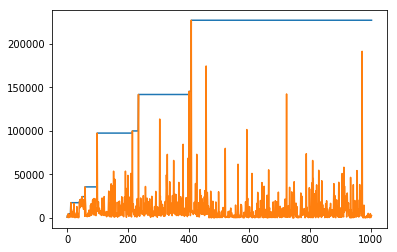

In [27]:
v = []
for i, res in enumerate(optimizer3.res):
    v.append(res['target'])
    
vn = []
for i, val in enumerate(v):
    mv = max(v[0:i+1])
    vn.append(mv)
    
plt.figure()
plt.plot(vn)
plt.plot(v)
plt.show()

In [28]:
df = pd.DataFrame({
    'CFV': v})
df.to_csv('CFV_Iter_6S_RFP.csv')

df = pd.DataFrame({
    'CFV': vn})
df.to_csv('bestCFV_Iter_6S_RFP.csv')

### Check results with plot

In [22]:
inputs = [round(optimizer3.max['params']['IPTG1'], 2)+1e-7, int(optimizer3.max['params']['aTc1'])+1e-7, 
          round(optimizer3.max['params']['IPTG2'], 2)+1e-7, int(optimizer3.max['params']['aTc2'])+1e-7, 
          round(optimizer3.max['params']['IPTG3'], 2)+1e-7, int(optimizer3.max['params']['aTc3'])+1e-7, 
          round(optimizer3.max['params']['IPTG4'], 2)+1e-7, int(optimizer3.max['params']['aTc4'])+1e-7, 
          round(optimizer3.max['params']['IPTG5'], 2)+1e-7, int(optimizer3.max['params']['aTc5'])+1e-7, 
          round(optimizer3.max['params']['IPTG6'], 2)+1e-7, int(optimizer3.max['params']['aTc6'])+1e-7]

ivss = [1,1e-7,1363.193,28.510]
pre = [1,1e-7]
sp = [int(i) for i in list(np.linspace(0,(24*60),7))]
t =  np.linspace(0,(24*60),(24*60)+1)

pM1 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model1.stan.csv"))
pM2 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model2.stan.csv"))

# Simulation of the system for the two models and extract of results
solM1 = solveALL(t, pM1, sp, inputs, ivss, pre, 'M1')
solM2 = solveALL(t, pM2, sp, inputs, ivss, pre, 'M2')

RFP_M1 = solM1[:,0:len(pM1[:,1])]
GFP_M1 = solM1[:,len(pM1[:,1]):(len(pM1[:,1])*2)]

RFP_M2 = solM2[:,0:len(pM2[:,1])]
GFP_M2 = solM2[:,len(pM2[:,1]):(len(pM2[:,1])*2)]


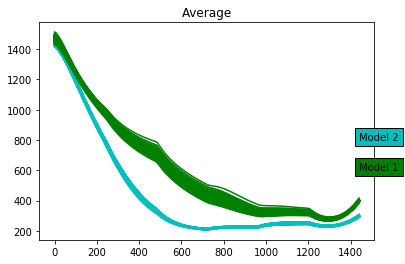

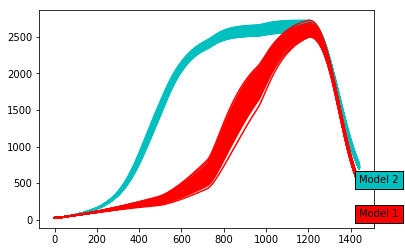

In [23]:
t = np.linspace(0,(24*60),round(24*60/5)+1)

plt.figure()
lines = plt.plot(t, GFP_M2, 'c')
plt.text((24*60)+1, 800, "Model 2", bbox=dict(facecolor='c'))
plt.title("Average")
lines2 = plt.plot(t, GFP_M1, 'g')
plt.text((24*60)+1, 600, "Model 1", bbox=dict(facecolor='g'))

plt.show()
plt.figure()
plt.plot(t, RFP_M2, 'c')

plt.text((24*60)+1, 500, "Model 2", bbox=dict(facecolor='c'))
plt.text((24*60)+1, 40, "Model 1", bbox=dict(facecolor='r'))
plt.plot(t, RFP_M1, 'r')
plt.show()

### Check utility decomposition results

In [ ]:
# Gaussian Process Regression and Reduction

# Means and standard deviations for each time point for each species and for each model
tgp = np.linspace(0,(24*60),(24*60/5)+1)

muR3 = RFP_M2.mean(axis = 1) # Model 2, RFP
sdR3 = RFP_M2.std(axis = 1)
muG3 = GFP_M2.mean(axis = 1) # Model 2, GFP
sdG3 = GFP_M2.std(axis = 1)
muR2 = RFP_M1.mean(axis = 1) # Model 1, RFP
sdR2 = RFP_M1.std(axis = 1)
muG2 = GFP_M1.mean(axis = 1) # Model 1, GFP
sdG2 = GFP_M1.std(axis = 1)

# Gaussian Process regression
gR3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR3, (sdR3**2)) # RFP, Model 2
gR3.findhyperparameters(noruns=15)
gR3.predict(tgp)

gG3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG3, (sdG3**2)) # GFP, Model 2
gG3.findhyperparameters(noruns=15)
gG3.predict(tgp)

gR2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR2, (sdR2**2)) # RFP, Model 1
gR2.findhyperparameters(noruns=15)
gR2.predict(tgp)

gG2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG2, (sdG2**2)) # GFP, Model 1
gG2.findhyperparameters(noruns=15)
gG2.predict(tgp)



In [ ]:
muref = list(np.matrix.transpose((np.random.multivariate_normal(gR3.mnp, gR3.covp, 2000)))[::10])
tref = list(tgp[::10])

g2R3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
g2R3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
g2R3.predict(tref)

muref = list(np.matrix.transpose((np.random.multivariate_normal(gR2.mnp, gR2.covp, 2000)))[::10])
tref = list(tgp[::10])

g2R2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
g2R2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
g2R2.predict(tref)

muref = list(np.matrix.transpose((np.random.multivariate_normal(gG3.mnp, gG3.covp, 2000)))[::10])
tref = list(tgp[::10])

g2G3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
g2G3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
g2G3.predict(tref)

muref = list(np.matrix.transpose((np.random.multivariate_normal(gG2.mnp, gG2.covp, 2000)))[::10])
tref = list(tgp[::10])

g2G2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
g2G2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
g2G2.predict(tref)

In [ ]:
bdR = BhattacharyyaDist(g2R3.mnp, g2R2.mnp, g2R3.covp, g2R2.covp)
bdG = BhattacharyyaDist(g2G3.mnp, g2G2.mnp, g2G3.covp, g2G2.covp)
u_B = (bdR*bdG)

In [ ]:
print("The BD for RFP is: ", str(bdR))
print("The BD for GFP is: ", str(bdG))
print("The multiplicative BD is: ", str(u_B))
print("The average BD is: ", str((bdR+bdG)/2))